# Relative Elevation Model

This tutorial is inspired by [this](https://dancoecarto.com/creating-rems-in-qgis-the-idw-method) blog post, [this](https://wadnr.maps.arcgis.com/apps/Cascade/index.html?appid=36b4887370d141fcbb35392f996c82d9) excellent story map, and [this](https://github.com/DahnJ/REM-xarray/blob/master/rem-in-xarray-tutorial.ipynb) notebook.

In [1]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xrspatial as xs
from datashader import transfer_functions as tf
from datashader import utils as ds_utils
from datashader.colors import Greys9, inferno
from scipy.spatial import KDTree
from shapely import ops

import py3dep
import pynhd

In [2]:
import warnings

warnings.filterwarnings("ignore", ".*invalid value encountered in.*")

Relative Elevation Model (REM) detrends a DEM based on the water surface of a stream. It's especially useful for visualization of floodplains. We're going to compute REM for a segment of Carson River and visualize the results using [xarray-spatial](https://xarray-spatial.org) and [datashader](https://datashader.org).

First, let's check out the available DEM resolutions in our area of interest (AOI).

In [3]:
bbox = (-119.59, 39.24, -119.47, 39.30)
dem_res = py3dep.check_3dep_availability(bbox)
dem_res

{'1m': True,
 '3m': False,
 '5m': False,
 '10m': True,
 '30m': True,
 '60m': False,
 'topobathy': False}

We can see that Lidar (1-m), 10-m, and 30-m are available. Obviously, Lidar data gives us the best results, but it can be computationally expensive. So, we're going to set the resolution to 10 m.

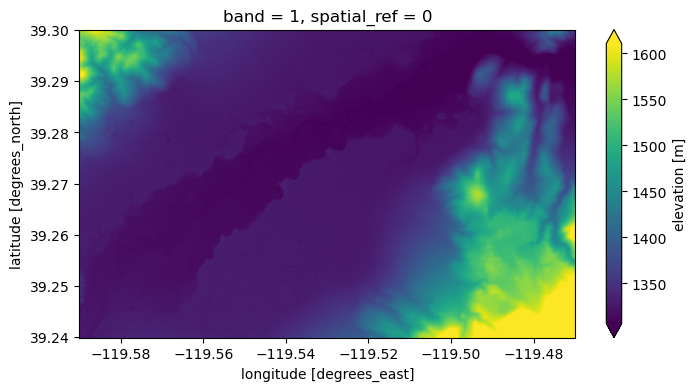

In [4]:
res = 10
dem = py3dep.get_dem(bbox, res)

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
_ = dem.plot(ax=ax, robust=True)

Next, we need to get the river's centerline. For this purpose, first we get the flowlines within our AOI. Then, we remove all the isolated flowlines using the `remove_isolated` flag of `pynhd.prepare_nhdplus` and find the main flowline based on the minimum value of the `levelpathi` attribute.

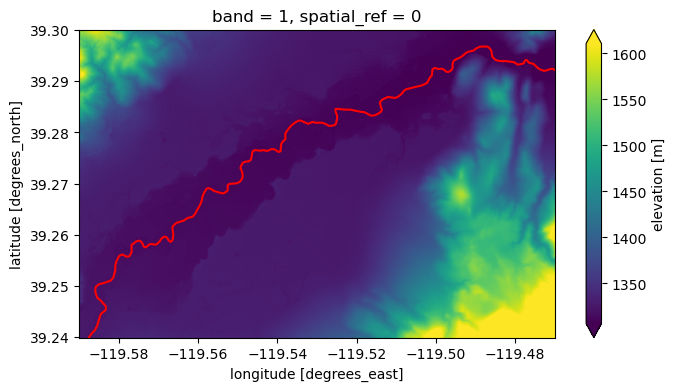

In [5]:
wd = pynhd.WaterData("nhdflowline_network")

flw = wd.bybox(bbox)
flw = pynhd.prepare_nhdplus(flw, 0, 0, 0, remove_isolated=True)
flw = flw[flw.levelpathi == flw.levelpathi.min()].copy()

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
flw.plot(ax=ax, color="r")
_ = dem.plot(ax=ax, robust=True)

Now, we can get the elevation profile along the obtained main flowline with spacing of 10 meters.

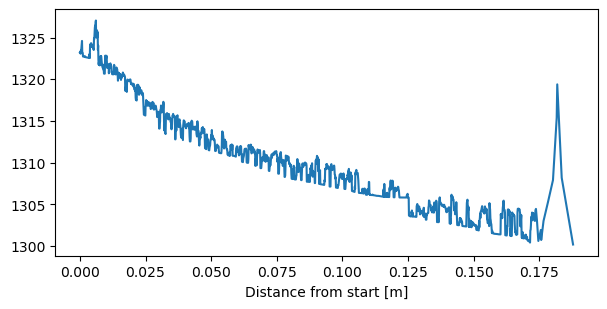

In [6]:
lines = ops.linemerge(flw.geometry.tolist())
riv_dem = py3dep.elevation_profile(lines, 10, crs=flw.crs)
_ = riv_dem.plot(x="distance", figsize=(7, 3.2))

There are several methods for detrending the DEM based on the river's elevation profile. You can check these method in [this](https://www.dnr.wa.gov/publications/ger_presentations_dmt_2016_coe.pdf) poster. Here, we're going to use Inverse Distance Weighting method using `scipy`'s `KDTree` function and setting the number of neighbors to 200.

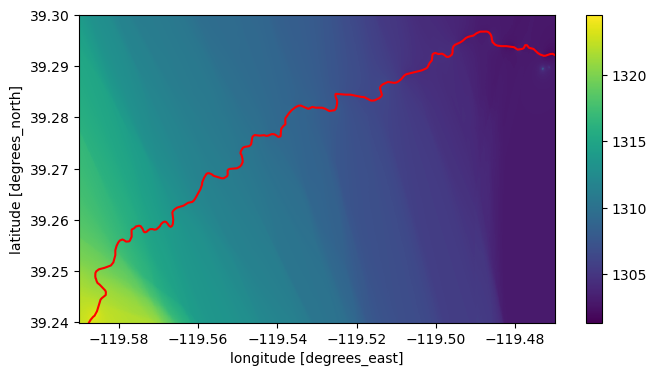

In [7]:
def idw(riv_dem: xr.DataArray, dem: xr.DataArray, n_nb: int) -> xr.DataArray:
    """Interpolate grid DEM from river DEM using Inverse Distance Weighting."""
    riv_coords = np.column_stack((riv_dem.x, riv_dem.y))
    kdt = KDTree(riv_coords)

    dem_grid = np.dstack(np.meshgrid(dem.x, dem.y)).reshape(-1, 2)
    distances, idx = kdt.query(dem_grid, k=n_nb)

    weights = np.reciprocal(distances)
    weights = weights / weights.sum(axis=1, keepdims=True)

    interp = weights * riv_dem.to_numpy()[idx]
    interp = interp.sum(axis=1).reshape((dem.sizes["y"], dem.sizes["x"]))
    return xr.DataArray(interp, dims=("y", "x"), coords={"x": dem.x, "y": dem.y})


elevation = idw(riv_dem, dem, 200)
rem = dem - elevation

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
elevation.plot(ax=ax)
_ = flw.plot(ax=ax, color="red")

Let's use datashader to stack DEM, Hillshade and REM for a nice visualization. There are a couple of parameters in this tutorial that can be change for extending it to other regions: Number of neighbors in IDW, DEM resolution, `span` argument of REM's shading operation.

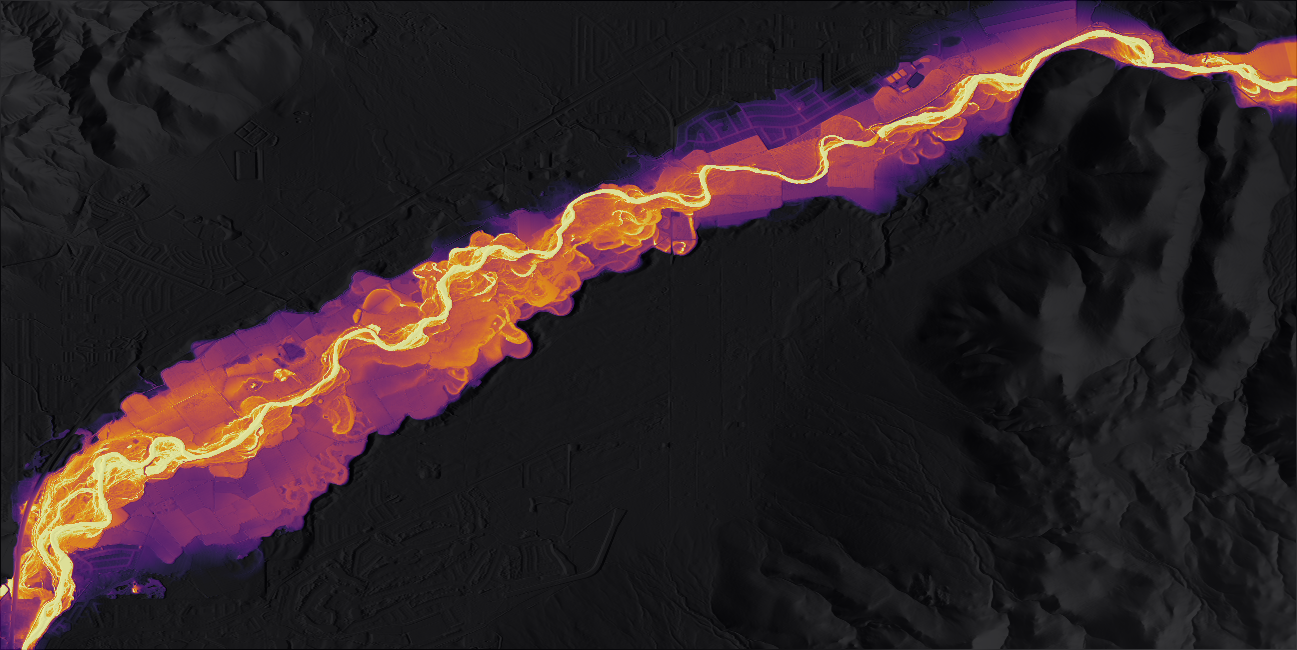

In [8]:
illuminated = xs.hillshade(dem, angle_altitude=10, azimuth=90)
tf.Image.border = 0
img = tf.stack(
    tf.shade(dem, cmap=Greys9, how="linear"),
    tf.shade(illuminated, cmap=["black", "white"], how="linear", alpha=180),
    tf.shade(rem, cmap=inferno[::-1], span=[0, 7], how="log", alpha=200),
)
ds_utils.export_image(img[::-1], Path("_static", "rem").as_posix())